### Author__ Hussam Qassim__

##  Predicting crimes in San Francisco using BLSTM neural network

Predicting crimes in San Francisco

A competition hosted by kaggle:
https://www.kaggle.com/c/sf-crime

# Setup

In [1]:
%matplotlib inline
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Import the main necessary libraries
import sys
from copy import deepcopy
import numpy
import pandas
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import Holiday, HolidayCalendarFactory, FR, DateOffset
import matplotlib.pyplot
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
import pylab
import os
import warnings
from distutils.version import LooseVersion
from datetime import datetime
import numpy as np
import csv
import re
import tensorflow as tf

# To make this notebook's output stable across runs
def rset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Check TensorFlow Version. Please use TensorFlow version 1.0 or newer
assert LooseVersion(tf.__version__) >= LooseVersion('1.0')
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.3.0


# Preprocessing the data 

['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']
Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB
Any missing values?
In train:  False
In 

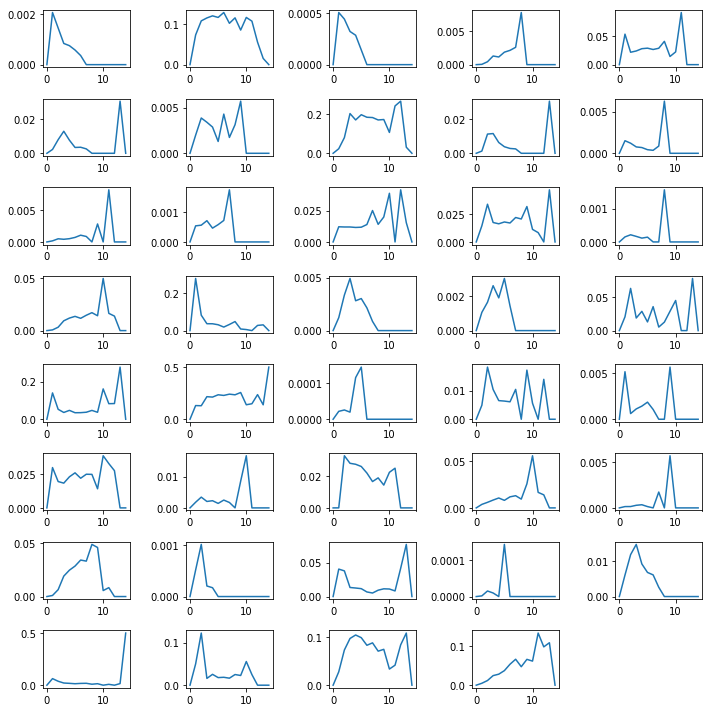

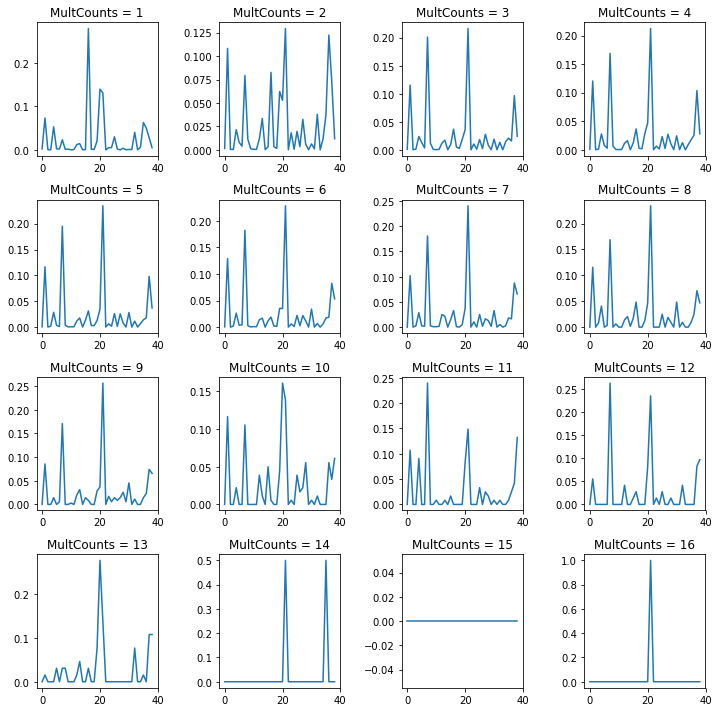

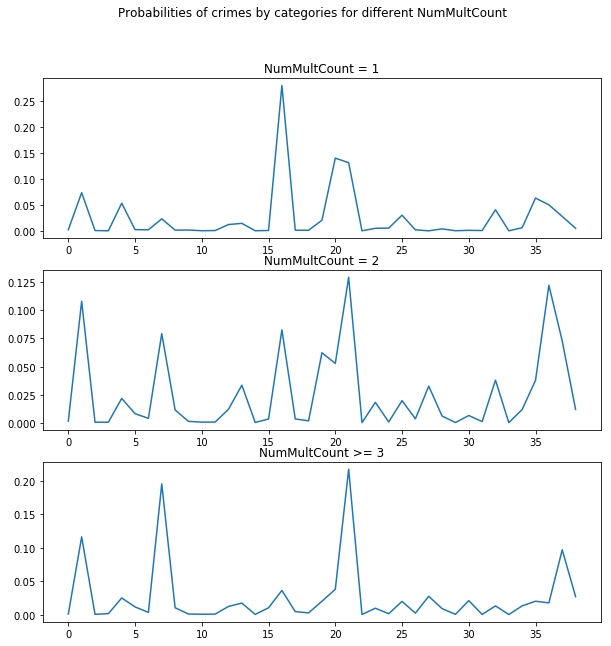

Any missing values?
In train:  False
In test:   False
365
1
Any data for February 29?
Empty DataFrame
Columns: [Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y, NumMultCrimes, MultProbs1, MultProbs2, MultProbs3, MultProbs4, MultProbs5, MultProbs6, MultProbs7, MultProbs8, MultProbs9, MultProbs10, MultProbs11, MultProbs12, MultProbs13, MultProbs14, MultProbs15, MultProbs16, MultProbs17, MultProbs18, MultProbs19, MultProbs20, MultProbs21, MultProbs22, MultProbs23, MultProbs24, MultProbs25, MultProbs26, MultProbs27, MultProbs28, MultProbs29, MultProbs30, MultProbs31, MultProbs32, MultProbs33, MultProbs34, MultProbs35, MultProbs36, MultProbs37, MultProbs38, MultProbs39, Date, Year, Month, Day, DayOfYear, Time, Hour, Minutes]
Index: []

[0 rows x 56 columns]


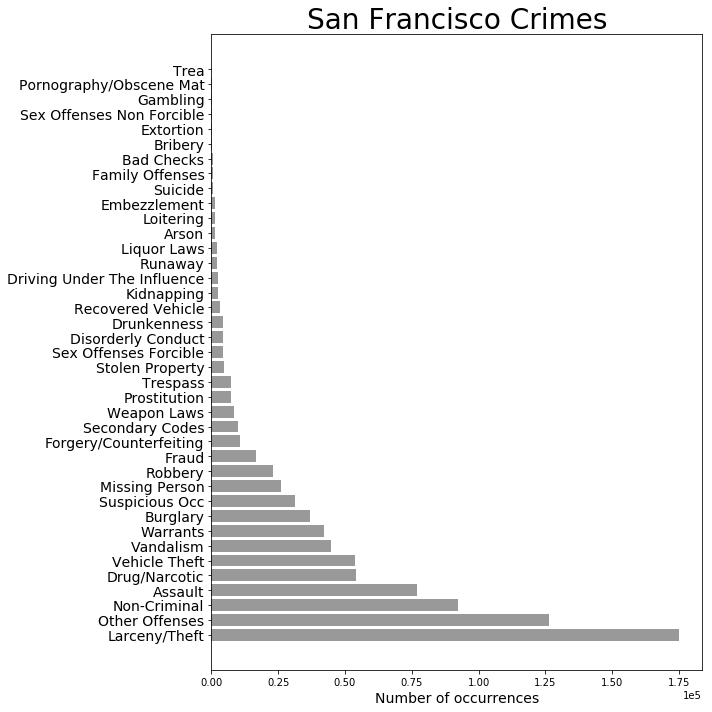

San Francisco Crimes

Category		Number of occurrences
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2

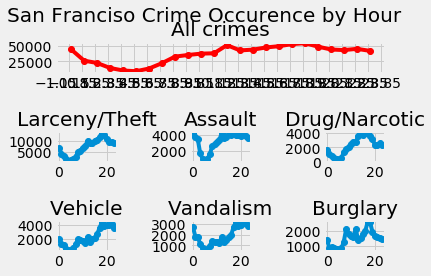

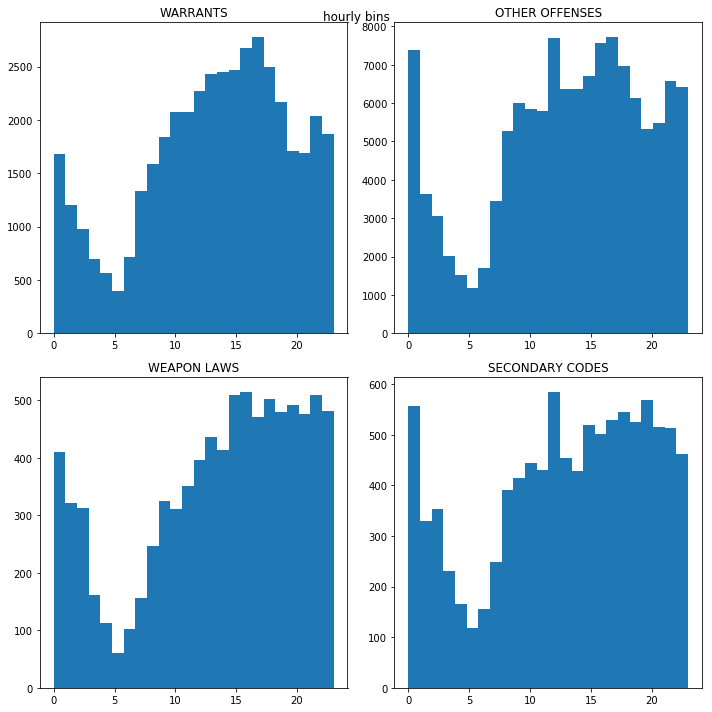

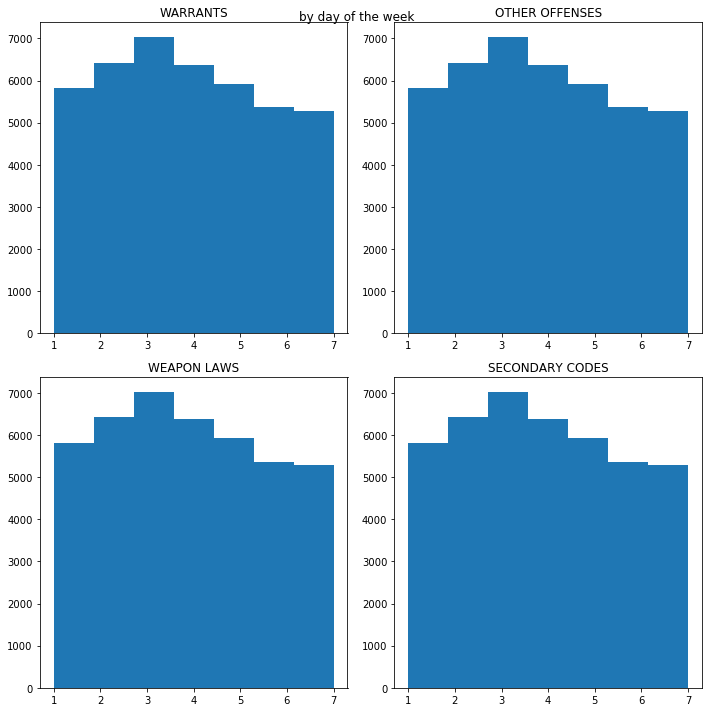

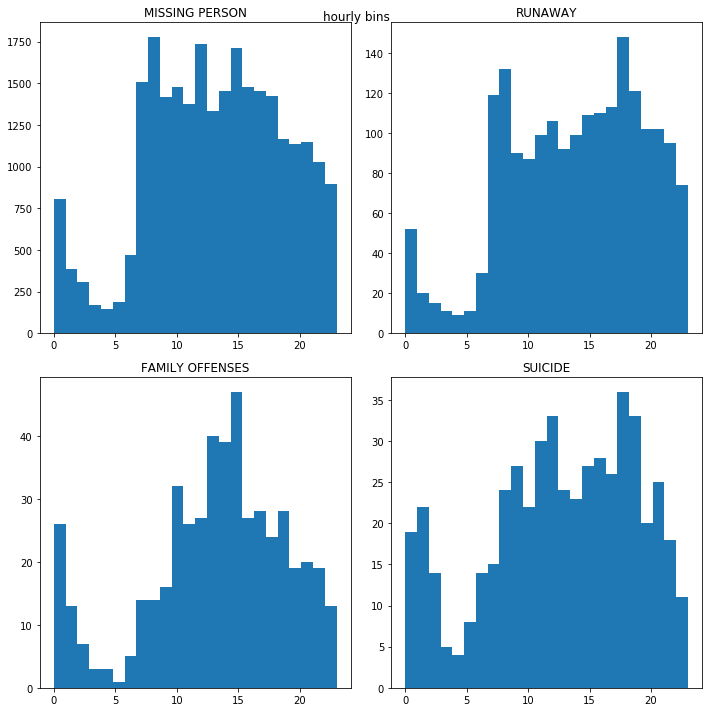

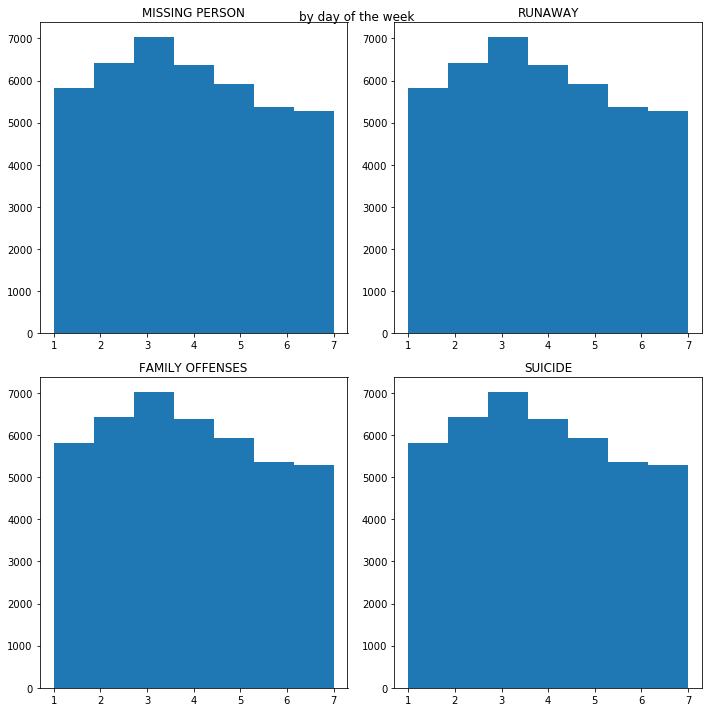

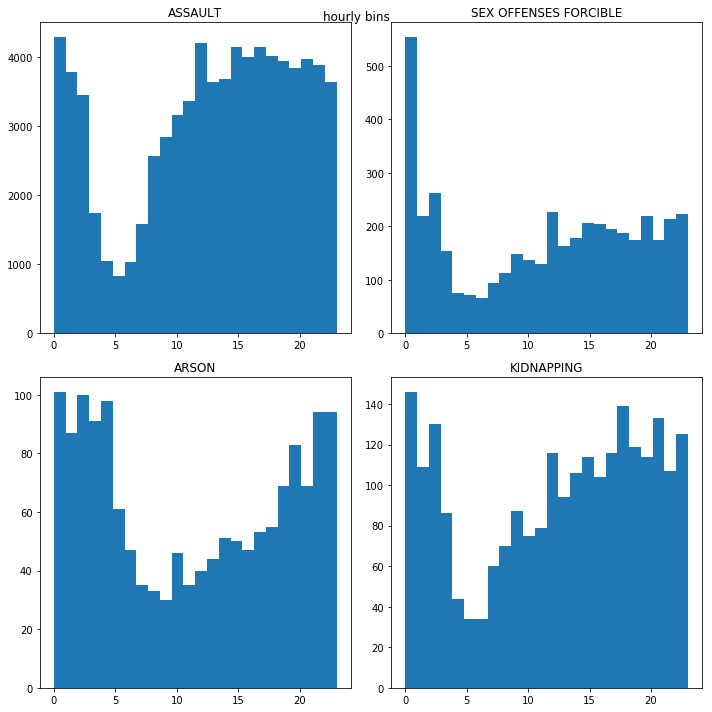

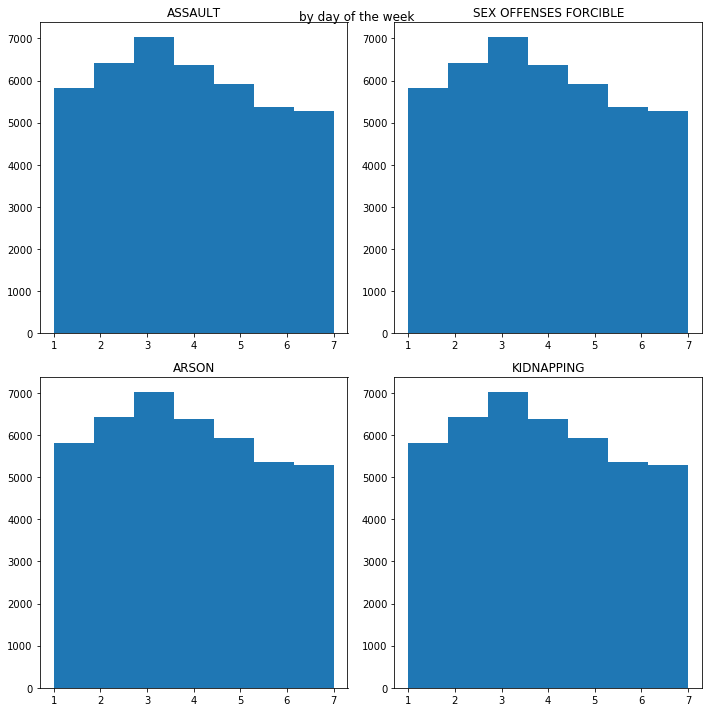

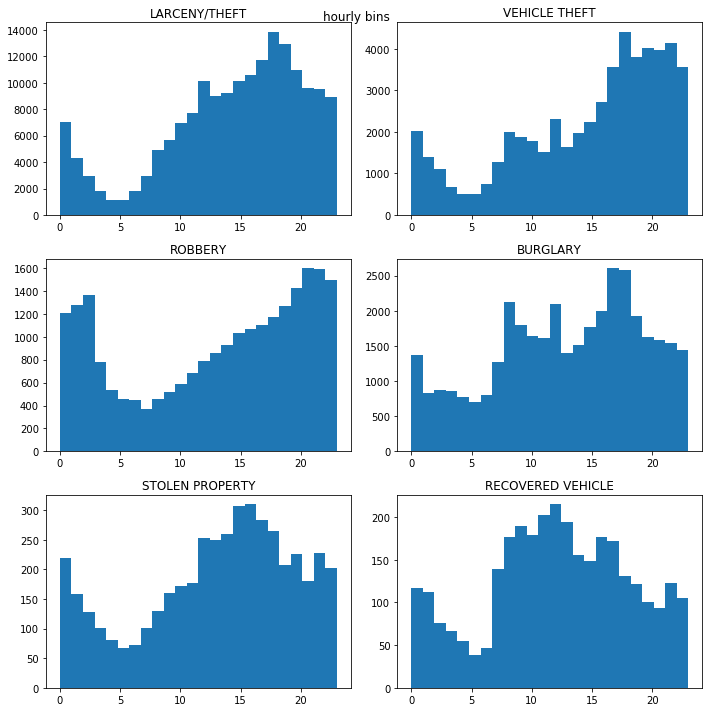

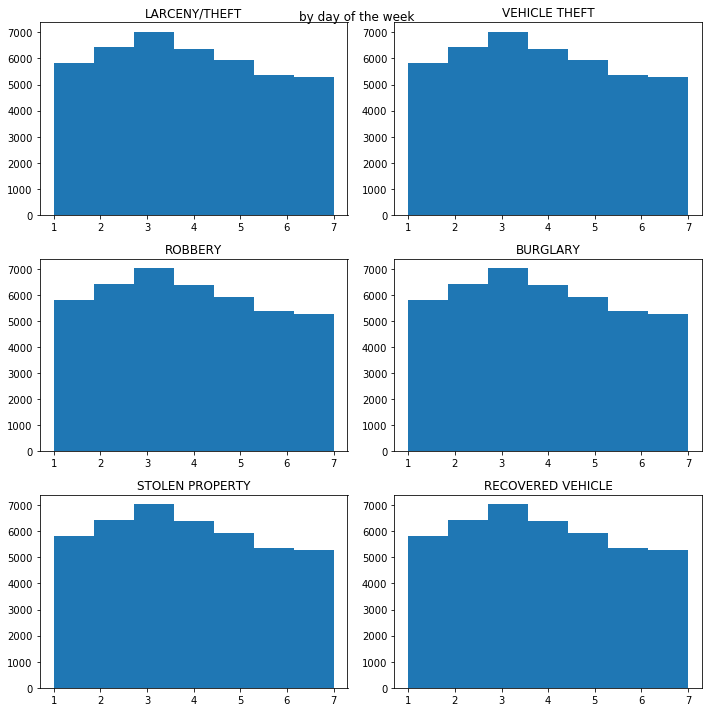

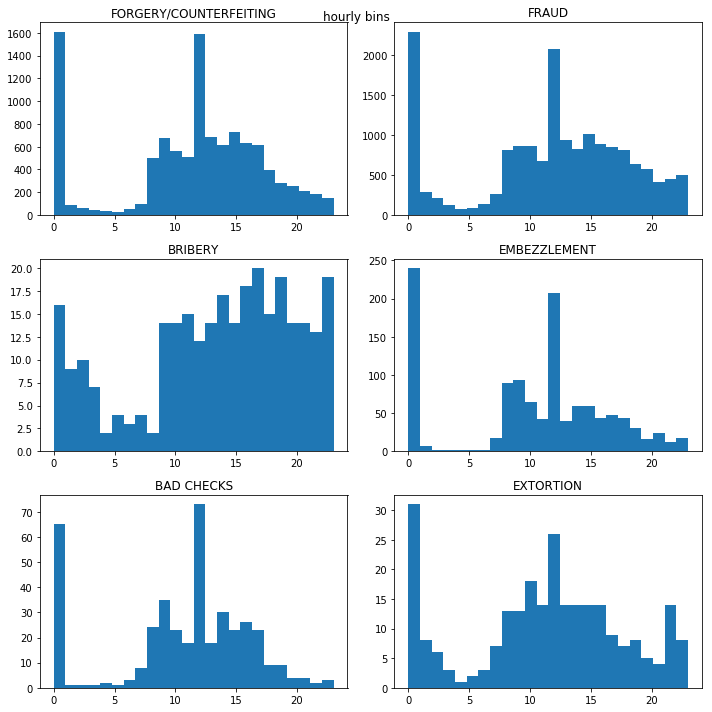

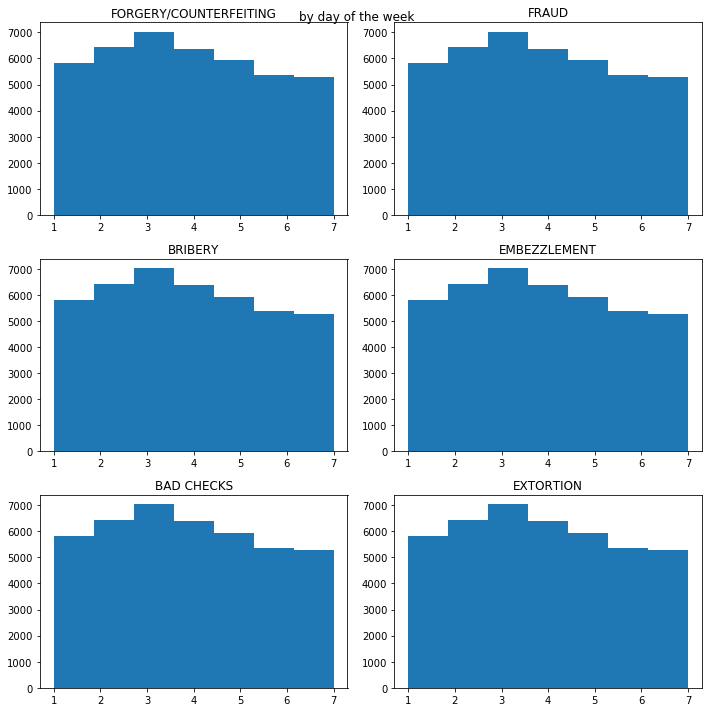

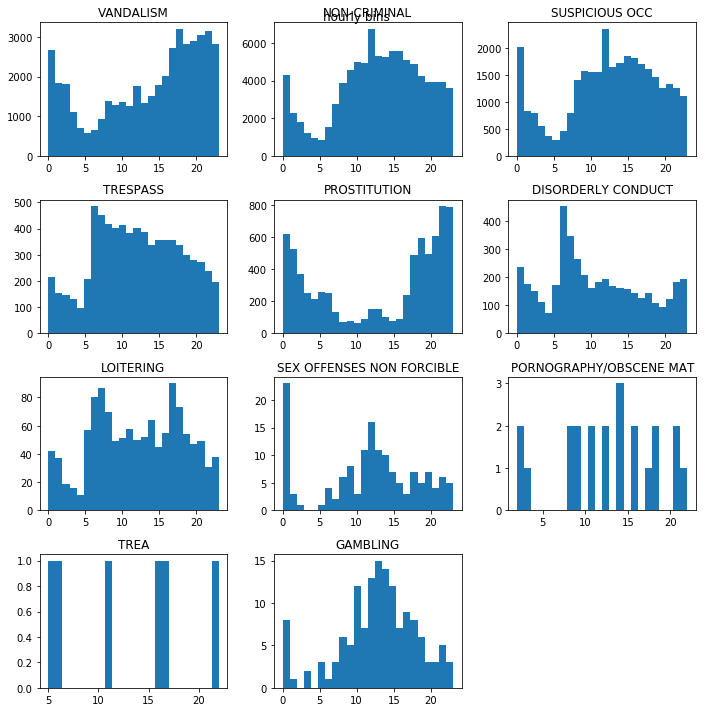

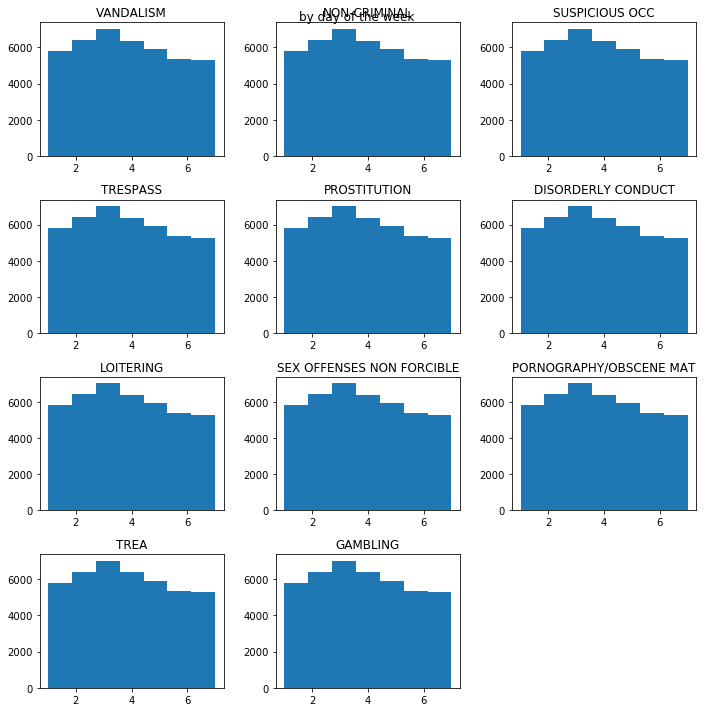

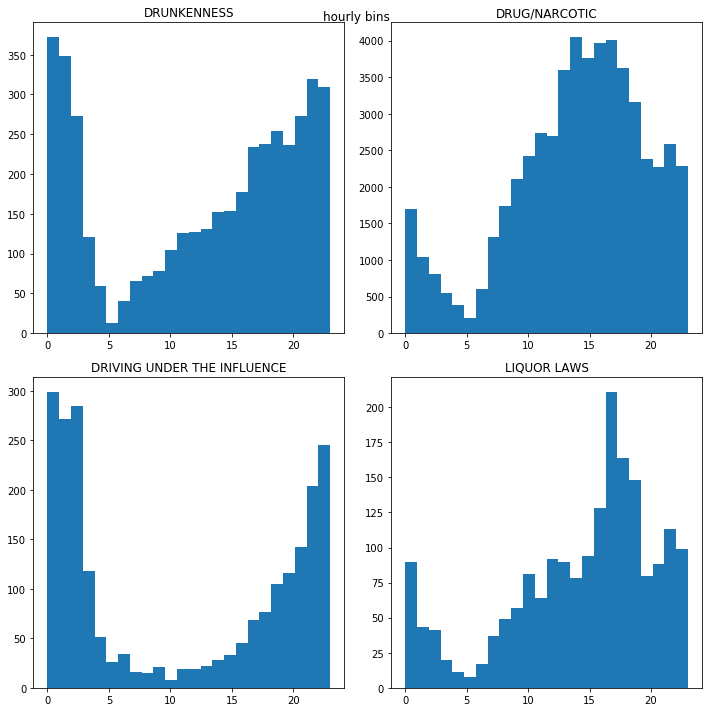

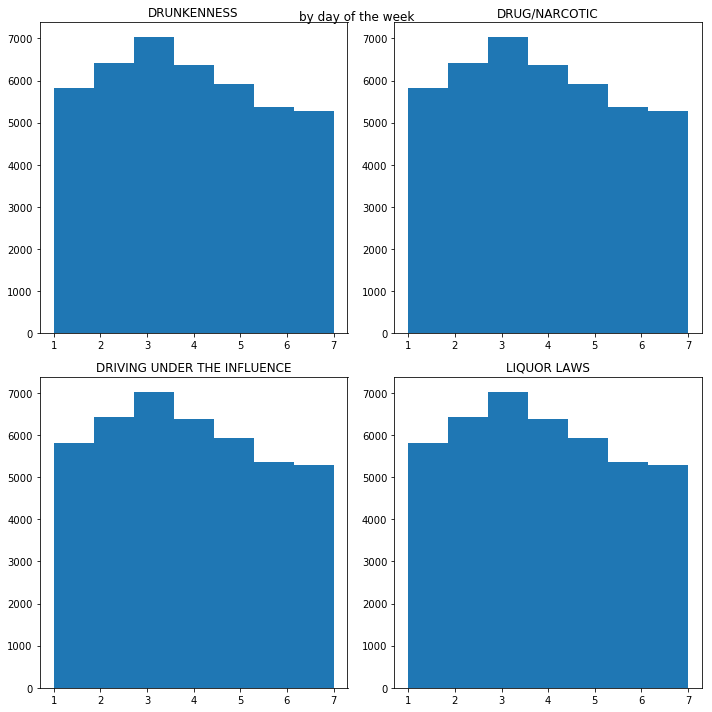

################################
Years for which we have data: 

[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
###################################
###################################
#############################
clean block addresses...
clean intersection addresses...
logodds munging of the addresses in train...


/home/hussam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:631: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


logodds munging of the addresses in test...


/home/hussam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:654: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


-122.513642064
-120.5
37.7078790224
90.0
How often are the coordinates wrong in train?
67
How often are the coordinates wrong in test?
76
['5TH OFARRELL' 'JAMESLICKFREEWAY SILVER' '5TH EDDY' '5TH ELLIS'
 'WILLIAMS YOSEMITE' 'BRENHAM WASHINGTON' 'GEARY PALMS' '19TH STCHARLES'
 '1ST BRANNAN' 'STJOSEPHS TURK' 'MONTGOMERY THEEMBARCADERONORTH'
 'DONNER FITCH' '7TH MCALLISTER' 'EUCLID PALMS' 'BEACH VANNESS'
 'LAGRANDE PERSIA' '3RD ISLAISCREEK' 'AUSTIN LARKIN' 'INGALLS JENNINGS'
 'GENEVA INTERSTATE280' 'ARGUELLO NORTHRIDGE' 'CHARLESJBRENHAM CLAY'
 'MONTEREY STELMO' 'I-280 PENNSYLVANIA' 'ALAMEDA FLORIDA'
 'CESARCHAVEZ I-280' 'BRYANT SPEAR' '4TH JAMESLICKFREEWAY'
 'GREENWICH THEEMBARCADERONORTH' 'FITCH GILMAN'
 'JOHNFKENNEDY MARTINLUTHERKINGJR' 'CESARCHAVEZ JAMESLICKFREEWAY'
 '3RD JAMESLICKFREEWAY' 'SPEAR THEEMBARCADEROSOUTH']
How often are the coordinates wrong in train?
0
How often are the coordinates wrong in test?
0
-122.513642064
-122.364937494
37.7078790224
37.8199754923


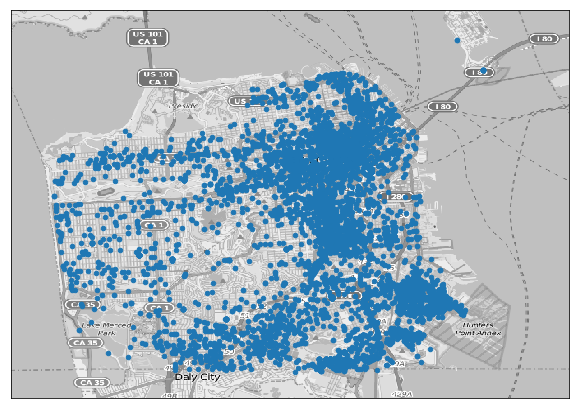

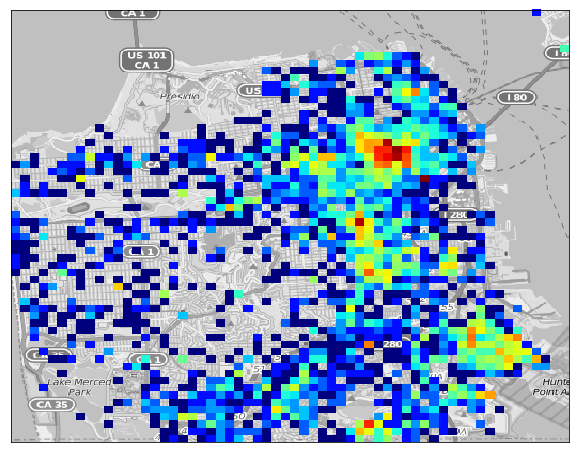

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
save the cleaned and engineered data to csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 95 columns):
Category         878049 non-null object
DayOfWeek        878049 non-null object
PdDistrict       878049 non-null object
X                878049 non-null float64
Y                878049 non-null float64
NumMultCrimes    878049 non-null object
MultProbs1       878049 non-null float64
MultProbs2       878049 non-null float64
MultProbs3       878049 non-null float64
MultProbs4       878049 non-null float64
MultProbs5       878049 non-null float64
MultProbs6       878049 non-null float64
MultProbs7       878049 non-null float64
MultProbs8       878049 non-null float64
MultProbs9       878049 non-null float64
MultProbs10      878049 non-null float64
MultProbs11      878049 non-null float64
MultProbs12      878049 non-null float64
Mul

In [2]:
# Load Data into pandas DataFrames
train = pandas.read_csv('data/train.csv', parse_dates=['Dates'])
test = pandas.read_csv('data/test.csv', parse_dates=['Dates'])

# Names of columns
print(list(train.columns.values))
print(list(test.columns.values))

# Data types of columns
print(train.dtypes)

train.info()

print('Any missing values?')
print('In train: ', pandas.isnull(train).values.any())
print('In test:  ', pandas.isnull(test).values.any())

'''

Sometimes, multiple crimes occur at the same place and time.
Those are probably linked, i.e. one deed involving several
different crimes.

This will certainly be important when building models. We'll
take that into account by adding a new column with the number
of simultaneous crimes and by computing the log odds of crimes
occurring simultaneously.

count the number of times when identical dates, x, and y appear in the data
i.e. multiple crimes committed in one act

'''

print('Multiple crimes in the test data')
counts = test.groupby(['Dates', 'X', 'Y']).size()

# The counts
numMult = counts.value_counts()
print(numMult)

# Largest number of simultaneous crimes in the test data
maxCrimesTest = max(counts)

# Add counts to test
counts = pandas.DataFrame(counts)
counts = counts.reset_index()
test = test.merge(counts, how='right')
test.rename(columns={0:'NumMultCrimes'}, inplace=True)

print('Multiple crimes in the training data')
counts = train.groupby(['Dates', 'X', 'Y']).size()

# The counts
print(counts.value_counts())

# Largest number of simultaneous crimes
maxCrimesTrain = max(counts)

# Add counts to train
counts = pandas.DataFrame(counts)
counts = counts.reset_index()
train = train.merge(counts, how='right')
train.rename(columns={0:'NumMultCrimes'}, inplace=True)

# We don't need counts anymore
del counts

# Sorted list of crime categories
categories=sorted(train['Category'].unique())
print(categories)

# Largest number of simultaneous crimes
maxCrimes = max(maxCrimesTest, maxCrimesTrain)
print('maxCrimes ', maxCrimes)
MultCounts = numpy.zeros((maxCrimes+1, len(categories)))
MultProbs = numpy.zeros((maxCrimes+1, len(categories)))

for i in range(len(categories)):
    for j in range(maxCrimes+1):
        MultCounts[j, i] = len(train.loc[(train['Category'] == categories[i]) & 
                                         (train['NumMultCrimes'] == j)].index)

for numc in range(1,maxCrimes+1):
    norm = MultCounts[numc].sum()
    for j in range(len(categories)):
        if (norm>0): MultProbs[numc, j] = MultCounts[numc, j]/norm

# Plot the probabilities of crimes to occur in a multiple crime
# by the count of multiple crimes for the different categories
# of offenses
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
for i in range(39):
    ax = 'ax'+str(i)
    ax = fig1.add_subplot(8, 5, i+1)
    ax.plot(MultProbs[:15,i])
    
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Plot the probability of crimes to occur in a multiple crime
# by the crime category for the different values of MultCount <= 16
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
for i in range(16):
    ax = 'ax'+str(i)
    ax = fig1.add_subplot(4, 4, i+1)
    ax.plot(MultProbs[i+1,:])
    ax.set_title('MultCounts = '+str(i+1))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Given those plots and the scarcity of data for NumMultCount >3
# we'll only consider NumMultCount 1, 2, and >= 3 separately from
# now on

MultCountsShort = numpy.zeros((4, len(categories)))
MultProbsShort = numpy.zeros((4, len(categories)))
MultLogOdds = numpy.zeros((4, len(categories)))

MultCountsShort[1,:] = MultCounts[1,:]
MultCountsShort[2,:] = MultCounts[2,:]
MultCountsShort[3,:] = MultCounts[3,:] + \
                       MultCounts[4,:] + \
                       MultCounts[5,:] + \
                       MultCounts[6,:] + \
                       MultCounts[7,:] + \
                       MultCounts[8,:] + \
                       MultCounts[9,:] + \
                       MultCounts[10,:] + \
                       MultCounts[11,:] + \
                       MultCounts[12,:] + \
                       MultCounts[13,:] + \
                       MultCounts[14,:] + \
                       MultCounts[15,:] + \
                       MultCounts[16,:]

# Compute the log odds for crimes to occur
# in a multiple crime event
for numc in range(1,4):
    norm = MultCountsShort[numc].sum()
    for j in range(len(categories)):
        if (norm>0): MultProbsShort[numc, j] = MultCountsShort[numc, j]/norm
        # replace probs by log odds
        if (MultProbsShort[numc, j] == 0):
            MultLogOdds[numc, j] = -34.5  # p = 1e-15
        elif (MultProbsShort[numc, j] == 1):
            MultLogOdds[numc, j] = 34.5  # p = 1-1e-15
        else:
            MultLogOdds[numc, j] = numpy.log(MultProbsShort[numc, j]) - numpy.log(1 - MultProbsShort[numc, j])

# Plot the condensed probability of crimes to occur in a multiple crime
# by the crime category for MultCount = 1, 2, and 3 or larger
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
ax0 = fig1.add_subplot(3, 1, 1)
ax1 = fig1.add_subplot(3, 1, 2)
ax2 = fig1.add_subplot(3, 1, 3)
ax0.plot(MultProbsShort[1,:])
ax1.plot(MultProbsShort[2,:])
ax2.plot(MultProbsShort[3,:])
ax0.set_title('NumMultCount = 1')
ax1.set_title('NumMultCount = 2')
ax2.set_title('NumMultCount >= 3')
fig1.suptitle('Probabilities of crimes by categories for different NumMultCount')
matplotlib.pyplot.show()

# Replace all values of NumMultCount > 3 by 3
train.loc[train['NumMultCrimes'] > 3, 'NumMultCrimes'] = 3
test.loc[test['NumMultCrimes'] > 3, 'NumMultCrimes'] = 3

# And turn them into factor levels
train['NumMultCrimes'] = train['NumMultCrimes'].astype('category')
test['NumMultCrimes'] = test['NumMultCrimes'].astype('category')

# Convert the log odds into a proper DataFrame
MultLogOdds = pandas.DataFrame(MultLogOdds)

# Add a column name
MultLogOdds.columns=["MultProbs"+str(x+1) for x in range(len(MultLogOdds.columns))]

# Drop row 0
MultLogOdds = MultLogOdds[1:]
MultLogOdds.insert(0, 'NumMultCrimes', list(range(1,4)))

# Add the log odds to train and test
train = train.merge(MultLogOdds, how='left')
test = test.merge(MultLogOdds, how='left')

# Cleaning up
del MultCounts
del MultProbs
del MultCountsShort
del MultProbsShort
del MultLogOdds

print('Any missing values?')
print('In train: ', pandas.isnull(train).values.any())
print('In test:  ', pandas.isnull(test).values.any())

'''

Taking care of the dates

'''

# Split Dates into new columns Date, Year, Month, Day, DayOfYear and Hour
train['Date'] = pandas.to_datetime(train['Dates'].dt.date)
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Day'] = train['Dates'].dt.day
train['DayOfYear'] = train['Dates'].dt.dayofyear   # the ordinal day of the year
train['Time'] = train['Dates'].dt.hour + train['Dates'].dt.minute/60
train['Hour'] = train['Dates'].dt.hour
train['Minutes'] = train['Dates'].dt.minute
del train['Dates']
test['Date'] = pandas.to_datetime(test['Dates'].dt.date)
test['Year'] = test['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['Day'] = test['Dates'].dt.day
test['DayOfYear'] = test['Dates'].dt.dayofyear   # the ordinal day of the year
test['Time'] = test['Dates'].dt.hour + test['Dates'].dt.minute/60
test['Hour'] = test['Dates'].dt.hour
test['Minutes'] = test['Dates'].dt.minute
del test['Dates']

print(max(train['DayOfYear']))
print(min(train['DayOfYear']))
print("Any data for February 29?")
print(train[(train['Month'] == 2) & (train['Day'] == 29)])

# There are no data for February 29 in any year, i.e. leap
# years are not considered properly, yet another problem
# we won't worry about

# Add column with named days of the week as number:
train.loc[train['DayOfWeek'] == 'Monday', 'DOW'] = 1
train.loc[train['DayOfWeek'] == 'Tuesday', 'DOW'] = 2
train.loc[train['DayOfWeek'] == 'Wednesday', 'DOW'] = 3
train.loc[train['DayOfWeek'] == 'Thursday', 'DOW'] = 4
train.loc[train['DayOfWeek'] == 'Friday', 'DOW'] = 5
train.loc[train['DayOfWeek'] == 'Saturday', 'DOW'] = 6
train.loc[train['DayOfWeek'] == 'Sunday', 'DOW'] = 7
test.loc[test['DayOfWeek'] == 'Monday', 'DOW'] = 1
test.loc[test['DayOfWeek'] == 'Tuesday', 'DOW'] = 2
test.loc[test['DayOfWeek'] == 'Wednesday', 'DOW'] = 3
test.loc[test['DayOfWeek'] == 'Thursday', 'DOW'] = 4
test.loc[test['DayOfWeek'] == 'Friday', 'DOW'] = 5
test.loc[test['DayOfWeek'] == 'Saturday', 'DOW'] = 6
test.loc[test['DayOfWeek'] == 'Sunday', 'DOW'] = 7



# Number of occurrences of different crimes
crimes_rating = train['Category'].value_counts()
y_pos = numpy.arange(len(crimes_rating[0:39].keys()))

matplotlib.pyplot.figure(figsize=(10,10))
matplotlib.pyplot.barh(y_pos, crimes_rating[0:39].get_values(),  align='center', alpha=0.4, color = 'black')
matplotlib.pyplot.yticks(y_pos, map(lambda x:x.title(),crimes_rating[0:39].keys()), fontsize = 14)
matplotlib.pyplot.xlabel('Number of occurrences', fontsize = 14)
matplotlib.pyplot.title('San Francisco Crimes', fontsize = 28)
matplotlib.pyplot.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

print ('San Francisco Crimes\n')
print ('Category\t\tNumber of occurrences') 
print (crimes_rating)

# A plot of the time of the day at which some crimes occur
larceny = train[train['Category'] == "LARCENY/THEFT"]
assault = train[train['Category'] == "ASSAULT"]
drug = train[train['Category'] == "DRUG/NARCOTIC"]
vehicle = train[train['Category'] == "VEHICLE THEFT"]
vandalism = train[train['Category'] == "VANDALISM"]
burglary = train[train['Category'] == "BURGLARY"]

with matplotlib.pyplot.style.context('fivethirtyeight'):
    ax1 = matplotlib.pyplot.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1.plot(train.groupby('Hour').size(), 'ro-')
    ax1.set_title('All crimes')
    start, end = ax1.get_xlim()
    ax1.xaxis.set_ticks(numpy.arange(start, end, 1))

    ax2 = matplotlib.pyplot.subplot2grid((3, 3), (1, 0))
    ax2.plot(larceny.groupby('Hour').size(), 'o-')
    ax2.set_title('Larceny/Theft')

    ax3 = matplotlib.pyplot.subplot2grid((3, 3), (1, 1))
    ax3.plot(assault.groupby('Hour').size(), 'o-')
    ax3.set_title('Assault')

    ax4 = matplotlib.pyplot.subplot2grid((3, 3), (1, 2))
    ax4.plot(drug.groupby('Hour').size(), 'o-')
    ax4.set_title('Drug/Narcotic')

    ax5 = matplotlib.pyplot.subplot2grid((3, 3), (2, 0))
    ax5.plot(vehicle.groupby('Hour').size(), 'o-')
    ax5.set_title('Vehicle')

    ax6 = matplotlib.pyplot.subplot2grid((3, 3), (2, 1))
    ax6.plot(vandalism.groupby('Hour').size(), 'o-')
    ax6.set_title('Vandalism')

    ax7 = matplotlib.pyplot.subplot2grid((3, 3), (2, 2))
    ax7.plot(burglary.groupby('Hour').size(), 'o-')
    ax7.set_title('Burglary')

    pylab.gcf().text(0.5, 0.98,
                     'San Franciso Crime Occurence by Hour',
                     horizontalalignment='center',
                     verticalalignment='top',
                     fontsize=20)

matplotlib.pyplot.tight_layout(2)
matplotlib.pyplot.show()


# Cleaning up
del larceny
del assault
del drug
del vehicle
del vandalism
del burglary

# Let's consider various subsets of crimes
# and plot their distributions by hour
# and day of the week

def plot_by_hour(category, nrow, ncol):
    fig1 = matplotlib.pyplot.figure(figsize=(10, 10))
    for i in range(1, len(category)+1):
        ax = 'ax' + str(i)
        ax = fig1.add_subplot(nrow, ncol, i)
        ax.hist(train.loc[train['Category'] == category[i - 1], 'Hour'], bins=24)
        ax.set_title(category[i - 1])
    matplotlib.pyplot.suptitle("hourly bins")
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

def plot_by_day(category, nrow, ncol):
    fig1 = matplotlib.pyplot.figure(figsize=(10, 10))
    for i in range(1, len(category)+1):
        ax = 'ax' + str(i)
        ax = fig1.add_subplot(nrow, ncol, i)
        ax.hist(train.loc[train['Category'] == otherCrimes[0], 'DOW'], bins=7)
        ax.set_title(category[i - 1])
    matplotlib.pyplot.suptitle("by day of the week")
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

otherCrimes = ['WARRANTS',
               'OTHER OFFENSES',
               'WEAPON LAWS',
               'SECONDARY CODES']

plot_by_hour(otherCrimes, 2, 2)
plot_by_day(otherCrimes, 2, 2)

familyCrimes = ['MISSING PERSON',
                'RUNAWAY',
                'FAMILY OFFENSES',
                'SUICIDE']

plot_by_hour(familyCrimes, 2, 2)
plot_by_day(familyCrimes, 2, 2)

violentCrimes = ['ASSAULT',
                 'SEX OFFENSES FORCIBLE',
                 'ARSON',
                 'KIDNAPPING']

plot_by_hour(violentCrimes, 2, 2)
plot_by_day(violentCrimes, 2, 2)

theftBurglary = ['LARCENY/THEFT',
                 'VEHICLE THEFT',
                 'ROBBERY',
                 'BURGLARY',
                 'STOLEN PROPERTY',
                 'RECOVERED VEHICLE']

plot_by_hour(theftBurglary, 3, 2)
plot_by_day(theftBurglary, 3, 2)

economicCrimes = ['FORGERY/COUNTERFEITING',
                  'FRAUD',
                  'BRIBERY',
                  'EMBEZZLEMENT',
                  'BAD CHECKS',
                  'EXTORTION']

plot_by_hour(economicCrimes, 3, 2)
plot_by_day(economicCrimes, 3, 2)

publicDisorder = ['VANDALISM',
                  'NON-CRIMINAL',
                  'SUSPICIOUS OCC',
                  'TRESPASS',
                  'PROSTITUTION',
                  'DISORDERLY CONDUCT',
                  'LOITERING',
                  'SEX OFFENSES NON FORCIBLE',
                  'PORNOGRAPHY/OBSCENE MAT',
                  'TREA',
                  'GAMBLING']

plot_by_hour(publicDisorder, 4, 3)
plot_by_day(publicDisorder, 4, 3)

drugsAlcohol = ['DRUNKENNESS',
                'DRUG/NARCOTIC',
                'DRIVING UNDER THE INFLUENCE',
                'LIQUOR LAWS']

plot_by_hour(drugsAlcohol, 2, 2)
plot_by_day(drugsAlcohol, 2, 2)


# We won't need the numbered days of the week any more
del train['DOW']
del test['DOW']

# Presumably, crime rates will be different on working days on the
# one hand and weekdays and holidays on the other hand.
# So we'll introduce a column WorkingDay

# Data on holidays and which businesses actually observe them are sketchy
# at best, so we'll only count the most important ones as holidays:
#  - New Year
#  - Memorial Day
#  - Independence Day
#  - Labor Day
#  - Thanksgiving
#  - Black Friday
#  - Christmas

cal = calendar()

# Need to remove rules in descending order!
cal.rules.pop(7) # remove Veterans Day
cal.rules.pop(6) # remove Columbus Day
cal.rules.pop(2) # remove President's Day
cal.rules.pop(1) # remove Martin Luther King Day

# Create new rule for Black Friday
USBlackFriday = Holiday('BlackFriday', month=11, day=1,
                            offset=DateOffset(weekday=FR(4)))

# Create own holiday calendar based on the above rules
ownCal = HolidayCalendarFactory('OwnCalendar', cal, USBlackFriday)
cal = ownCal()
holidays = cal.holidays(start='2003-01-01', end='2015-05-13')

# Set flag according to whether the day is a holiday, a weekend or not
train['Workingday'] = ((train['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) &
                       (train['Date'].isin(holidays)==False))
test['Workingday'] = ((test['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) &
                      (test['Date'].isin(holidays)==False))

# Transform from True/False into 1/0
train['Workingday'] = train['Workingday'].astype(int)
test['Workingday'] = test['Workingday'].astype(int)

print('Years for which we have data: \n')
print(train.Year.unique())
print(test.Year.unique())

print('###################################')

# checking for daylight saving Hour
# For example in 2014, DST started on March 9 at 2 am,
# i.e. there should be no Hour stamps between 2am and 3am
# Those Hourstamp do exist, however, hence DST seems not
# to be implemented in the data, one fewer complication
# to worry about

print('###################################')
# Introduce a new column denoting whether it is night or not
train['Night'] = True
test['Night'] = True

train.loc[(train['Month'] ==  1) & (train['Time'] > 7.3) & (train['Time'] < 17.3), 'Night'] = False
train.loc[(train['Month'] ==  2) & (train['Time'] > 7.0) & (train['Time'] < 17.8), 'Night'] = False
train.loc[(train['Month'] ==  3) & (train['Time'] > 6.3) & (train['Time'] < 18.3), 'Night'] = False
train.loc[(train['Month'] ==  4) & (train['Time'] > 5.5) & (train['Time'] < 18.8), 'Night'] = False
train.loc[(train['Month'] ==  5) & (train['Time'] > 5.0) & (train['Time'] < 19.3), 'Night'] = False
train.loc[(train['Month'] ==  6) & (train['Time'] > 4.8) & (train['Time'] < 19.5), 'Night'] = False
train.loc[(train['Month'] ==  7) & (train['Time'] > 5.0) & (train['Time'] < 19.5), 'Night'] = False
train.loc[(train['Month'] ==  8) & (train['Time'] > 5.5) & (train['Time'] < 19.0), 'Night'] = False
train.loc[(train['Month'] ==  9) & (train['Time'] > 5.8) & (train['Time'] < 18.3), 'Night'] = False
train.loc[(train['Month'] == 10) & (train['Time'] > 6.3) & (train['Time'] < 17.5), 'Night'] = False
train.loc[(train['Month'] == 11) & (train['Time'] > 6.8) & (train['Time'] < 17.0), 'Night'] = False
train.loc[(train['Month'] == 12) & (train['Time'] > 7.3) & (train['Time'] < 16.9), 'Night'] = False
test.loc[(test['Month'] ==  1) & (test['Time'] > 7.3) & (test['Time'] < 17.3), 'Night'] = False
test.loc[(test['Month'] ==  2) & (test['Time'] > 7.0) & (test['Time'] < 17.8), 'Night'] = False
test.loc[(test['Month'] ==  3) & (test['Time'] > 6.3) & (test['Time'] < 18.3), 'Night'] = False
test.loc[(test['Month'] ==  4) & (test['Time'] > 5.5) & (test['Time'] < 18.8), 'Night'] = False
test.loc[(test['Month'] ==  5) & (test['Time'] > 5.0) & (test['Time'] < 19.3), 'Night'] = False
test.loc[(test['Month'] ==  6) & (test['Time'] > 4.8) & (test['Time'] < 19.5), 'Night'] = False
test.loc[(test['Month'] ==  7) & (test['Time'] > 5.0) & (test['Time'] < 19.5), 'Night'] = False
test.loc[(test['Month'] ==  8) & (test['Time'] > 5.5) & (test['Time'] < 19.0), 'Night'] = False
test.loc[(test['Month'] ==  9) & (test['Time'] > 5.8) & (test['Time'] < 18.3), 'Night'] = False
test.loc[(test['Month'] == 10) & (test['Time'] > 6.3) & (test['Time'] < 17.5), 'Night'] = False
test.loc[(test['Month'] == 11) & (test['Time'] > 6.8) & (test['Time'] < 17.0), 'Night'] = False
test.loc[(test['Month'] == 12) & (test['Time'] > 7.3) & (test['Time'] < 16.9), 'Night'] = False

# Trasform from True/False into 1/0
train['Night'] = train['Night'].astype(int)
test['Night'] = test['Night'].astype(int)

print("#############################")

# Let's have a look at the addresses

adr = train['Address'].unique()
with open("data/Addresses.txt", 'w') as f:
    for s in adr:
        f.write(s + '\n')

# check whether address is an intersection or not
# one column, i.e. 1 for intersection and 0 for block should suffice
train['StreetCorner'] = train['Address'].apply(lambda x: 1 if '/' in x else 0)
test['StreetCorner'] = test['Address'].apply(lambda x: 1 if '/' in x else 0)

# Clearly, there are plenty of misspellings and
# identical entries not recognizable as such,
# i.e. A ST / B ST and B ST / A ST
#
# Let's deal with that
# We'll treat intersections and blocks separately

def combine(str1, str2):
    # Combine str1 and str2 ordered alphabetically
    return sorted([str1, str2], key=str.lower)[0] + ' ' + sorted([str1, str2], key=str.lower)[1]

def cleanIntersectionAddress(intAddress):
    intAddress['Street_1'] = intAddress['Address'].str.split('/').str[0].str.rstrip()
    intAddress['Street_2'] = intAddress['Address'].str.split('/').str[1].str.lstrip()
    # Replace VIA * by *
    intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('VIA'), 
                       'Street_1'].str.replace('VIA', '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('VIA'), 
                       'Street_2'].str.replace('VIA', '').str.lstrip()
    # Replace AVENUE OF THE PALMS by PALMS
    intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'), 'Street_1'] = \
        intAddress.loc[intAddress['Street_1'].str.startswith('AVENUE'),
                       'Street_1'].str.replace('AVENUE OF THE', '').str.lstrip()
    intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 'Street_2'] = \
        intAddress.loc[intAddress['Street_2'].str.startswith('AVENUE'), 
                       'Street_2'].str.replace('AVENUE OF THE', '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        intAddress.loc[intAddress['Street_1'].str.endswith(key), 'Street_1'] = \
            intAddress.loc[intAddress['Street_1'].str.endswith(key), 
                           'Street_1'].str.replace(key, '').str.rstrip()
        intAddress.loc[intAddress['Street_2'].str.endswith(key), 'Street_2'] = \
            intAddress.loc[intAddress['Street_2'].str.endswith(key), 
                           'Street_2'].str.replace(key, '').str.rstrip()

    # Remove all whitespaces
    intAddress['Street_1'] = intAddress['Street_1'].str.replace(' ', '')
    intAddress['Street_2'] = intAddress['Street_2'].str.replace(' ', '')

    # Create new address for the replacement, combine the names
    # in Street_1 and Street_2 in alphabetical ordering
    intAddress['Address'] = intAddress.apply(lambda x: combine(x['Street_1'], x['Street_2']), axis=1)
    return intAddress['Address']

def cleanBlockAddress(blockAddress):
    # Remove 'Block' and 'of' from address
    mapping = [('Block', ''),
               ('of', '')
               ]
    for key, value in mapping:
        blockAddress['Address'] = blockAddress['Address'].str.replace(key, value)

    # Get number from address
    blockAddress['Number'] = blockAddress['Address'].str.split().str[0]
    # Get street name from address, remove leading whitespaces
    blockAddress['Street'] = blockAddress['Address'].str.split(' ', 1).str[1].str.lstrip()
    del blockAddress['Address']
    # Replace VIA * by *
    blockAddress.loc[blockAddress['Street'].str.startswith('VIA'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('VIA'),
                         'Street'].str.replace('VIA', '').str.lstrip()
    # Replace AVENUE OF THE PALMS by PALMS
    blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 'Street'] = \
        blockAddress.loc[blockAddress['Street'].str.startswith('AVENUE'), 
                         'Street'].str.replace('AVENUE OF THE', '').str.lstrip()
    removeList = [' AL', ' AV', ' BL', ' CR', ' CT', ' DR', ' EX', ' HWY', ' HY',
                  ' LN', ' PL', ' PZ', ' RD', ' RW', ' ST', ' STWY', ' TER',
                  ' TR', ' WAY', ' WK', ' WY', 'STNORTH']
    for key in removeList:
        blockAddress.loc[blockAddress['Street'].str.endswith(key), 'Street'] = \
            blockAddress.loc[blockAddress['Street'].str.endswith(key), 
                             'Street'].str.replace(key, '').str.rstrip()

    # Remove all whitespaces
    blockAddress['Street'] = blockAddress['Street'].str.replace(' ', '')
    # Create new address for the replacement
    blockAddress['Address'] = blockAddress['Number'] + ' ' + blockAddress['Street']
    return blockAddress['Address']


print('clean block addresses...')
train.loc[train['StreetCorner'] == 0, 'Address'] = \
    cleanBlockAddress(pandas.DataFrame(train.loc[train['StreetCorner'] == 0, 'Address']))
test.loc[test['StreetCorner'] == 0, 'Address'] = \
    cleanBlockAddress(pandas.DataFrame(test.loc[test['StreetCorner'] == 0, 'Address']))

print('clean intersection addresses...')
train.loc[train['StreetCorner'] == 1, 'Address'] = \
    cleanIntersectionAddress(pandas.DataFrame(train.loc[train['StreetCorner'] == 1, 'Address']))
test.loc[test['StreetCorner'] == 1, 'Address'] = \
    cleanIntersectionAddress(pandas.DataFrame(test.loc[test['StreetCorner'] == 1, 'Address']))

addresses = sorted(train["Address"].unique())
categories = sorted(train["Category"].unique())
Cat_counts = train.groupby(["Category"]).size()
Addr_Cat_counts = train.groupby(["Address","Category"]).size()
Addr_counts = train.groupby(["Address"]).size()

print('logodds munging of the addresses in train...')
logodds = {}
logoddsPA = {}
MIN_CAT_COUNTS = 5
default_logodds = numpy.log(Cat_counts/len(train))-numpy.log(1.0-Cat_counts/len(train))
for addr in addresses:
    PA = Addr_counts[addr]/len(train)
    logoddsPA[addr] = numpy.log(PA)-numpy.log(1.-PA)
    logodds[addr] = deepcopy(default_logodds)
    for cat in Addr_Cat_counts[addr].keys():
        if (Addr_Cat_counts[addr][cat]>MIN_CAT_COUNTS) and Addr_Cat_counts[addr][cat]<Addr_counts[addr]:
            AC = Addr_Cat_counts[addr][cat]/Addr_counts[addr]
            logodds[addr][categories.index(cat)] = numpy.log(AC)-numpy.log(1.0-AC)
    logodds[addr] = pandas.Series(logodds[addr])
    logodds[addr].index = range(len(categories))

addressLogodds = train["Address"].apply(lambda x: logodds[x])
addressLogodds.columns = ["logodds"+str(x) for x in range(len(addressLogodds.columns))]

train = train.join(addressLogodds.ix[:,:])

train['LogoddsPA'] = train["Address"].apply(lambda x: logoddsPA[x])

print('logodds munging of the addresses in test...')

new_addresses=sorted(test["Address"].unique())
new_Addr_counts=test.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_Addr_counts[addr]/float(len(test)+len(train))
    logoddsPA[addr]=numpy.log(PA)-numpy.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(Addr_counts[addr]+new_Addr_counts[addr])/float(len(test)+len(train))
    logoddsPA[addr]=numpy.log(PA)-numpy.log(1.-PA)

addressLogodds = test["Address"].apply(lambda x: logodds[x])
addressLogodds.columns=["logodds"+str(x) for x in range(len(addressLogodds.columns))]

test = test.join(addressLogodds.ix[:,:])

test['LogoddsPA'] = test["Address"].apply(lambda x: logoddsPA[x])

# Some map plots

#Latitude and longitude of map data
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

# Which latitudes and longitudes do we have in the data?
print(min(train['X']))
print(max(train['X']))
print(min(train['Y']))
print(max(train['Y']))

# Clearly some values are wrong

print('How often are the coordinates wrong in train?')
print(train.loc[train['Y'] > 38].count()['Y'])
print('How often are the coordinates wrong in test?')
print(test.loc[test['Y'] > 38].count()['Y'])

wrongLatAdr = train.loc[train['Y'] > 38, 'Address']
print(wrongLatAdr.unique())

# Fortunately, there are comparatively few instances of wrong coordinates
# for simplicity we'll just impute the values with the median for the
# corresponding Police district

# Medians of X and Y by police district
listOfPrecincts = train['PdDistrict'].unique()
precinctX = (train.groupby('PdDistrict'))['X'].median()
precinctY = (train.groupby('PdDistrict'))['Y'].median()

# Impute wrong values with the medians
for i in range(len(listOfPrecincts)) :
    train.loc[ (train['Y'] > 38) & (train['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
        precinctX[listOfPrecincts[i]]
    train.loc[(train['Y'] > 38) & (train['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
        precinctY[listOfPrecincts[i]]
    test.loc[ (test['Y'] > 38) & (test['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
        precinctX[listOfPrecincts[i]]
    test.loc[(test['Y'] > 38) & (test['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
        precinctY[listOfPrecincts[i]]

# Check that replacement worked
print('How often are the coordinates wrong in train?')
print(train.loc[train['Y'] > 38].count()['Y'])
print('How often are the coordinates wrong in test?')
print(test.loc[test['Y'] > 38].count()['Y'])

# Which latitudes and longitudes do we have in the data?
print(min(train['X']))
print(max(train['X']))
print(min(train['Y']))
print(max(train['Y']))

# Latitude and longitude of map data
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

mapdata = numpy.loadtxt("data/sf_map_copyright_openstreetmap_contributors.txt")

# Scatter plot
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat_box, cmap=matplotlib.pyplot.get_cmap('gray'))
ax1.scatter(train.loc[train['Category'] == otherCrimes[2]].X,train.loc[train['Category'] == 
                                                                       otherCrimes[2]].Y,s=20)
ax1.get_xaxis().set_ticks([])
ax1.get_xaxis().set_ticklabels([])
ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_ticklabels([])
matplotlib.pyplot.show()

# 2d histogram
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat_box, cmap=matplotlib.pyplot.get_cmap('gray'))
ax1.hist2d(train.loc[train['Category'] == otherCrimes[2]].X,train.loc[train['Category'] == 
                                                                      otherCrimes[2]].Y,
           bins=60, norm=LogNorm(), cmap=matplotlib.pyplot.cm.jet)
ax1.get_xaxis().set_ticks([])
ax1.get_xaxis().set_ticklabels([])
ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_ticklabels([])
matplotlib.pyplot.show()

print(train['PdDistrict'].unique())

# Drop the predictors we no longer need
del train['Descript']
del train['Resolution']
del train['Address']
del train['Date']

del test['Address']
del test['Date']

print('save the cleaned and engineered data to csv')
train.to_csv('data/train_new.csv', index=False)
test.to_csv('data/test_new.csv', index=False)

print('train.info', train.info())
print('test.info', test.info())

# Load ans scale the cleaned and engineered data

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

# Create the label
label = []
with open('data/train_new.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for i, row in enumerate(reader):
        if i == 0:
            pass
        else:
            category_string = row[0]
            y_label = category_string
            label.append(y_label)
            
# Label binarization
category_set = set()
for y in label:
    category_set.add(y)
category_dict = {item: i for i, item in enumerate(sorted(category_set))}
print('The num_unique_category: ', len(category_dict)) 
for i, y in enumerate(label):
    label[i] = category_dict[y]
            
# Load the cleaned and engineered data
train=pandas.read_csv('data/train_new.csv')

# StandardScaler-scale the raw x-y

xy_scaler = preprocessing.StandardScaler() 
xy_scaler.fit(train[["X","Y"]]) 
train[["X","Y"]]=xy_scaler.transform(train[["X","Y"]]) 

# Add some new features based on latitude and longitude:
# rotate coordinates by 30, 45 and 60 degreees
# and compute radial distance from center

train["rot45_X"] = 0.707* train["Y"] + 0.707* train["X"]
train["rot45_Y"] = 0.707* train["Y"] - 0.707* train["X"]
train["rot30_X"] = 0.866* train["X"] + 0.5* train["Y"]
train["rot30_Y"] = 0.866* train["Y"] - 0.5* train["X"]
train["rot60_X"] = 0.5* train["X"] + 0.866* train["Y"]
train["rot60_Y"] = 0.5* train["Y"] - 0.866* train["X"]
train["radial_r"] = numpy.sqrt( numpy.power(train["Y"],2) + numpy.power(train["X"],2) )


training = train
del training['Category']


# One-hot encoding
encoder = LabelBinarizer()
training['PdDistrict'] = encoder.fit_transform(training.PdDistrict)
training['DayOfWeek'] = encoder.fit_transform(training.DayOfWeek)

# Convert the Training and the Label data to suitable data type for TF 
training = np.asarray(training, dtype=np.float32)
label = np.asarray(label, dtype=np.int32)

# Normalizing the data
scaler = MinMaxScaler()
training = scaler.fit_transform(training)

print('Done..')

The num_unique_category:  39
Done..


# Build the Training, Validation and Test datasets

In [4]:
# Divide the dataset randomly because the data have been split in such a way that the training set consists
# of the odd numbered weeks, while the test data contains the even numbered weeks (we just using training data)
# into 80% Training, 10% Validation, and 10% Testing  
'''
split_idx = int(len(training)*0.8)
train_x, val_x = training[:split_idx], training[split_idx:]
train_y, val_y = label[:split_idx], label[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]
'''

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(training, label, test_size=0.2, random_state=42)

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(702439, 101) 
Validation set: 	(87805, 101) 
Test set: 		(87805, 101)


# Build the Neural Network

In [5]:
# Define the Neural Network parameters
lstm_size = 64
batch_size = 250
n_layers = 2
drop_out = 0.5
threshold = 0.9
learning_rate = 0.001
epochs = 100
n_features = 101 
n_steps = 1

print('Done..')

Done..


### Create TF Placeholders for the Neural Network

In [6]:
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, n_steps, n_features], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')   
print('Done..')

Done..


# Construction phase_ Build the TF graph 

### Build NN Cell and Initialize

In [7]:
'''
Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence 
as-is and the second on a reversed copy of the input sequence. This can provide additional context to the 
network and result in faster and even fuller learning on the problem
'''
# Build one BLSTM and Fully_connected layer with Softmax classifier
with graph.as_default():
    
# Using He initialization can significantly reduce the vanishing/exploding gradients problems   
    he_init = tf.contrib.layers.variance_scaling_initializer()
 
 # Create the graph of one input LSTM and 2 hidden BLSTM layer and one output layer
    with tf.name_scope("LSTM"):    
        basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
        outputs, states = tf.nn.dynamic_rnn(basic_cell, inputs=inputs_, dtype=tf.float32)


    with tf.name_scope("BLSTM"):
        def lstm_cell():
            '''
This LSTM variant with extra connections called peephole connections: the previous long-term state is added as
an input to the controllers of the forget gate and the input gate, and the current long-term tate is added as
input to the controller of the output gate
'''
            cell = tf.contrib.rnn.LSTMCell(num_units=lstm_size, initializer=he_init, use_peepholes=True)
            '''
            Applying dropout between the LSTM layers to prevent overfitting the training set.The following 
code applies dropout to the inputs of each layer in the LSTM, dropping each input with a 50% probability
'''
            cell_drop = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
            return cell_drop
    
        cell_fw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(n_layers)])
        cell_bw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(n_layers)])
   
        outputs, final_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell_fw, cell_bw=cell_bw, 
                                                          inputs=outputs, dtype=tf.float32, 
                                                          scope="BiLSTM")
        outputs = tf.concat(axis = 2, values = outputs)
        last_output = outputs[:,-1,:]
    
        logits = tf.contrib.layers.fully_connected(last_output, 39, activation_fn=None, scope="logits")
        
# Create the cost function     
    with tf.name_scope("loss"): 

# Computes the cross entropy, it is equivalent to applying the softmax activation function and then
# computing the cross entropy, but it is more efficient, and it properly takes care of corner cases like logits 
# equal to 0

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
# Computes the mean of elements across dimensions of a tensor
        loss = tf.reduce_mean(xentropy, name="loss")
                
# Craete the optimizer 
    with tf.name_scope("train"): 
# Applying clip the gradients technique to lessen the exploding gradient problem in the LSTM
# Using Adam as optimizer because it is combines the ideas of Momentum optimization and RMSProp
# Adam is an adaptive learning rate algorithm, it requires less tuning of the learning rate hyperparameter η. 
# We can often use the default value η = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        grads_and_vars = optimizer.compute_gradients(loss)
        capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
                                     for grad, var in grads_and_vars]
        training_op = optimizer.apply_gradients(capped_gvs)
        
# Evaluate the NN     
    with tf.name_scope("eval"):    
        correct = tf.nn.in_top_k(logits, labels_, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy" )

print('Done..')

Done..


### Baching the dataset

In [8]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        
print('Done..')

Done..


# Execution phase_Execute the TF graph 

### Training the model

In [9]:
# initialize a name and file directory for TensorBoard
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

# Create a Saver node
with graph.as_default():
    saver = tf.train.Saver()
    
# Create early stopping      
early_stopping = 0 

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer()) # initialize all variables
    
# Creates a node in the graph that will evaluate the reduce_mean value and write it to a TensorBoard 
# compatible binary log string called a summary 
    loss_summary = tf.summary.scalar("accuracy", accuracy)

# Creates a FileWriter that you will use to write summaries to logfiles in the log directory
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    print('training ..')
    
    for epoch in range(epochs):
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            x = x[:,np.newaxis,:]
            
# Update the execution phase to evaluate the loss_summary node regularly during training(every 10 mini-batches)
            if ii % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={inputs_: x, labels_: y, keep_prob: drop_out})
                step = epochs * batch_size + ii
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={inputs_: x, labels_: y, keep_prob: drop_out})
        acc_train = accuracy.eval(feed_dict={inputs_: x, labels_: y, keep_prob: drop_out})
        for x, y in get_batches(val_x, val_y, batch_size):
            x = x[:,np.newaxis,:]
            acc_val = accuracy.eval(feed_dict={inputs_: x, labels_: y, keep_prob: 1})
        print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val)
        if acc_val >= early_stopping:
            # Save the best trained model
            saver.save(sess, "checkpoints/sentiment.ckpt")
            early_stopping = acc_val
                        
file_writer.close()

training ..
0 Train accuracy: 0.308 Validation accuracy: 0.348
1 Train accuracy: 0.336 Validation accuracy: 0.336
2 Train accuracy: 0.348 Validation accuracy: 0.344
3 Train accuracy: 0.332 Validation accuracy: 0.356
4 Train accuracy: 0.348 Validation accuracy: 0.352
5 Train accuracy: 0.356 Validation accuracy: 0.344
6 Train accuracy: 0.324 Validation accuracy: 0.336
7 Train accuracy: 0.348 Validation accuracy: 0.348
8 Train accuracy: 0.328 Validation accuracy: 0.32
9 Train accuracy: 0.348 Validation accuracy: 0.34
10 Train accuracy: 0.364 Validation accuracy: 0.34
11 Train accuracy: 0.364 Validation accuracy: 0.332
12 Train accuracy: 0.348 Validation accuracy: 0.344
13 Train accuracy: 0.332 Validation accuracy: 0.344
14 Train accuracy: 0.376 Validation accuracy: 0.336
15 Train accuracy: 0.364 Validation accuracy: 0.332
16 Train accuracy: 0.356 Validation accuracy: 0.34
17 Train accuracy: 0.352 Validation accuracy: 0.34
18 Train accuracy: 0.34 Validation accuracy: 0.34
19 Train accuracy

### Testing the model

In [10]:
with tf.Session(graph=graph) as sess:

    print('Loading the saved checkpoint..')
# Load the saved model 
    saver.restore(sess, "checkpoints/sentiment.ckpt")
    print('Testing..')
# Baching the test dataset
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        x = x[:,np.newaxis,:]
        acc_test = accuracy.eval(feed_dict={inputs_: x, labels_: y, keep_prob: 1})
    print("Test accuracy:", acc_test)

Loading the saved checkpoint..
INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Testing..
Test accuracy: 0.352
